# Setup

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
import math
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from scipy.stats import mannwhitneyu

In [6]:
# This is to clear the warnings from the notebook, usually we should leave this on
import warnings
warnings.filterwarnings('ignore') 

# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

# PreProcessing Data

In [7]:
# Load clean data
data = pd.read_csv('/content/drive/MyDrive/1. Uni/QBUS3820/QBUS3820 - Group 13/airbnb_clean.csv')
data.head()

,id,name,description,neighbourhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,...,review_communication,review_location,review_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11156,"['oasis', 'city']","['central', 'city', 'reached', 'easy', 'walk',...","['close', 'everything', 'everywhere', 'many', ...",40855,Colleen,2009-09-23,"Potts Point, New South Wales, Australia","['recently', 'retired', 'lived', 'worked', 'co...",missing,...,4.77,4.82,4.71,False,False,1,0,1,0,1.34
1,14250,"['manly', 'harbour', 'house']","['beautifully', 'renovated', 'spacious', 'quie...","['balgowlah', 'heights', 'one', 'prestigious',...",55948,Heidi,2009-11-20,"Sydney, New South Wales, Australia","['canadian', 'made', 'australia', 'home', 'ten...",within a few hours,...,4.33,4.67,4.33,True,False,2,2,0,0,0.04
2,15253,"['unique', 'designer', 'rooftop', 'apartment',...","['penthouse', 'living', 'best', 'staying', 'un...","['location', 'really', 'central', 'number', 't...",59850,Morag,2009-12-03,"Sydney, New South Wales, Australia","['originally', 'scottish', 'made', 'sydney', '...",within an hour,...,4.67,4.7,4.47,True,True,1,0,1,0,3.21
3,44545,"['sunny', 'darlinghurst', 'warehouse', 'apartm...","['sunny', 'warehouseloft', 'apartment', 'heart...","['darlinghurst', 'home', 'sydney', 'best', 're...",112237,Atari,2010-04-22,"Sydney, New South Wales, Australia","['curious', 'world', 'full', 'wanderlust', 'ai...",missing,...,4.96,4.93,4.77,False,False,1,1,0,0,0.56
4,58506,"['studio', 'yindi', 'mosman', 'sydney']","['open', 'plan', 'apartment', 'opens', 'onto',...","['mosman', 'smart', 'middle', 'upper', 'class'...",279955,John,2010-11-06,"Sydney, New South Wales, Australia","['faber', 'est', 'suae', 'quisquae', 'fortunae...",within a few hours,...,4.9,4.73,4.68,True,False,1,1,0,0,2.23


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20880 entries, 0 to 20879
Data columns (total 55 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            20880 non-null  int64  
 1   name                                          20880 non-null  object 
 2   description                                   20880 non-null  object 
 3   neighbourhood_overview                        20880 non-null  object 
 4   host_id                                       20880 non-null  int64  
 5   host_name                                     20877 non-null  object 
 6   host_since                                    20877 non-null  object 
 7   host_location                                 20859 non-null  object 
 8   host_about                                    20880 non-null  object 
 9   host_response_time                            20880 non-null 

## Drop Data

In [9]:
data = data.drop(['id', 'host_id'], axis = 1)

## Transform data

In [10]:
# transform host_since from object to datetime
data['host_since'] = pd.to_datetime(data['host_since'], dayfirst = True, format = '%Y/%m/%d', errors = 'coerce')

In [11]:
# transform response_percent from object to float

data_response_percent = []

for x in data['response_percent']:
  if x == 'missing':
    value = np.nan
  else:
    value = x
  data_response_percent.append(pd.to_numeric(value, downcast = 'float'))
data['response_percent'] = data_response_percent

In [12]:
# transform acceptance_percent from object to float

data_acceptance_percent = []

for x in data['acceptance_percent']:
  if x == 'missing':
    value = np.nan
  else:
    value = x
  data_acceptance_percent.append(pd.to_numeric(value, downcast = 'float'))
data['acceptance_percent'] = data_acceptance_percent

In [13]:
# transform reviews_per_month from object to float

data_reviews_per_month = []

for x in data['reviews_per_month']:
  if x == 'missing':
    value = np.nan 
  else:
    value = x
  data_reviews_per_month.append(pd.to_numeric(value, downcast = 'float'))
data['reviews_per_month'] = data_reviews_per_month

In [14]:
# mean function
def find_mean(variable):
  total = 0
  count = 0
  for x in data[variable]:
    if x != 'missing':
      total += pd.to_numeric(x, downcast = 'float')
      count += 1

    avg = total / count
    return avg

In [15]:
# transform reviews from object to float
review_scores_all = ['review_rating', 'review_accuracy', 'review_cleanliness', 'review_checkin', 
                     'review_communication', 'review_location' , 'review_value']

for review in review_scores_all:
  avg = find_mean(review)
  data_reviews = []
  for x in data[review]:
    if x == 'missing':
      value = np.nan 
    else:
      value = x
    data_reviews.append(pd.to_numeric(value, downcast = 'float'))
  data[review] = data_reviews

# Bivariate EDA

## Variable Selection for Bivariate EDA

In [16]:
date_bivariate = data.copy()

In [17]:
data_bivariate = date_bivariate.drop(['name', 'description', 'neighbourhood_overview', 'host_name', 'host_location', 
                                      'host_about', 'host_neighbourhood', 'amenities'], axis = 1)

## Bivariate EDA

In [18]:
# for x in data_bivariate.columns:
#   print(type(data[x][0]))
#   print(x)

In [19]:
# # Log transform 'price'
# data['price'] = np.log(data['price'])

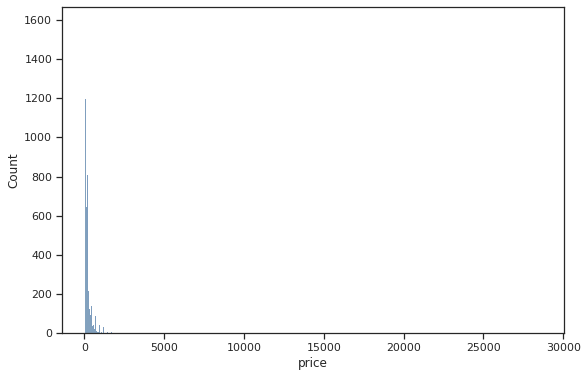

In [20]:
sns.histplot(data['price'])

### Numerical Bivariate

In [21]:
def numerical_bivariate_EDA(variable):
  x = data[variable]
  y = data['price']

  print(variable)
  
  print('')

  sns.scatterplot(x, y)
  plt.title('Scatter Plot of Price and {}'.format(variable))
  plt.show()

  print('')

In [22]:
for x in data_bivariate.columns:
  if isinstance(data[x][0], float) or isinstance(data[x][0], np.integer) or x == 'host_since':
    print(x)

host_since
response_percent
acceptance_percent
listings_count
latitude
longitude
accommodates
bedrooms
beds
price
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_nights_avg_ntm
maximum_nights_avg_ntm
availability_30
availability_365
number_of_reviews
review_rating
review_accuracy
review_cleanliness
review_checkin
review_communication
review_location
review_value
calculated_host_listings_count
calculated_host_listings_count_entire_homes
calculated_host_listings_count_private_rooms
calculated_host_listings_count_shared_rooms
reviews_per_month


host_since



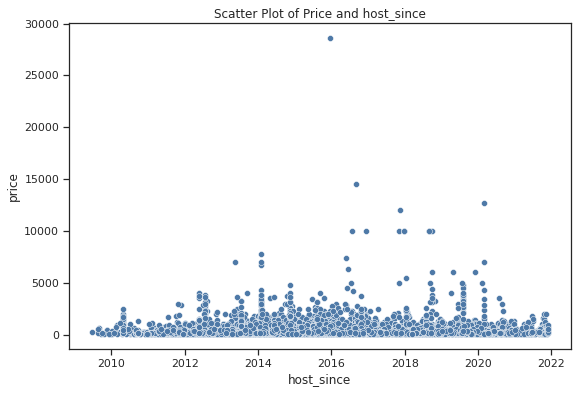


response_percent



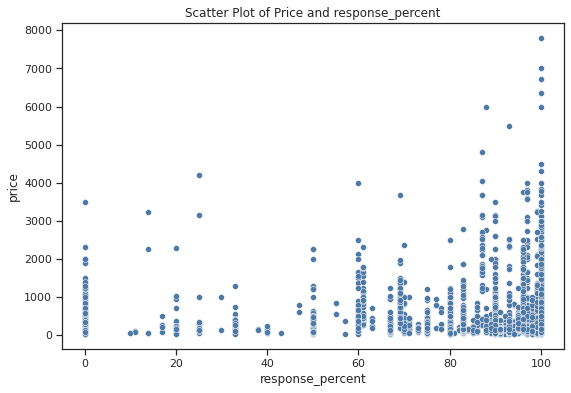


acceptance_percent



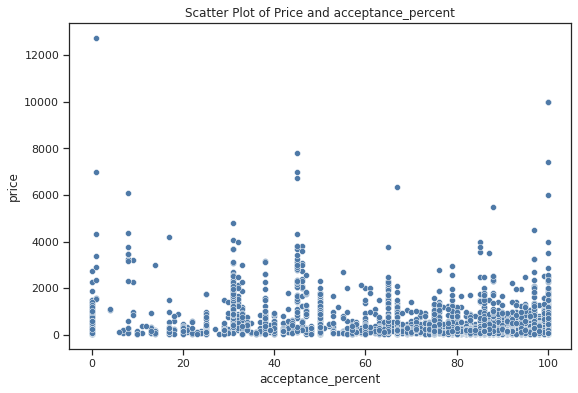


listings_count



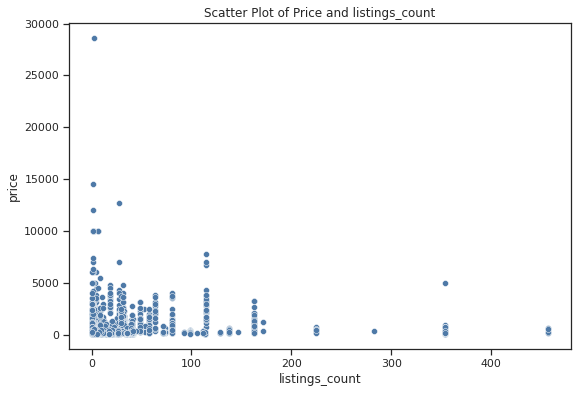


latitude



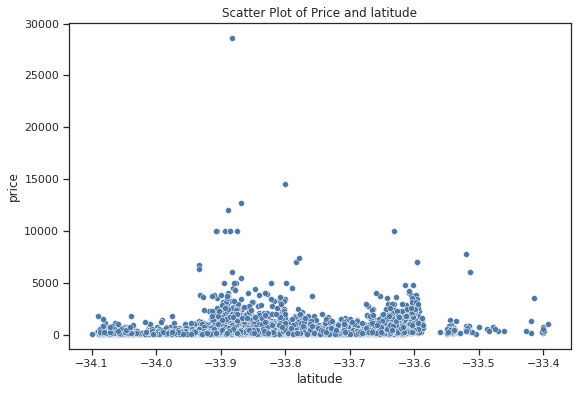


longitude



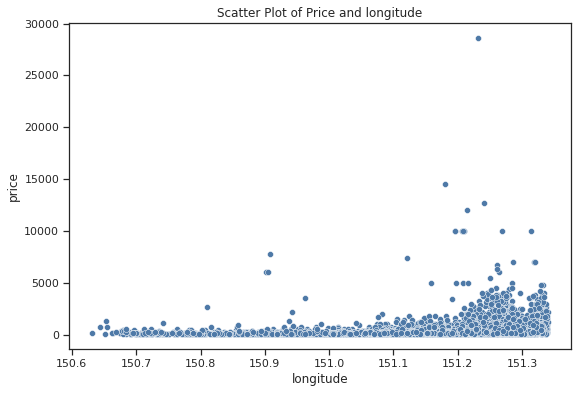


accommodates



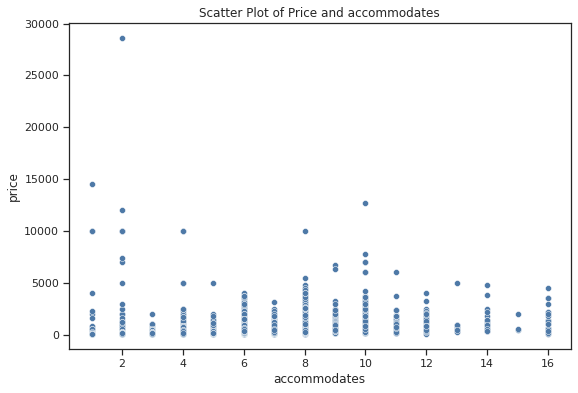


bedrooms



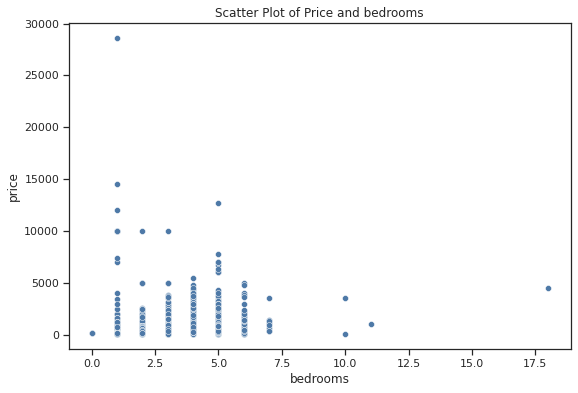


beds



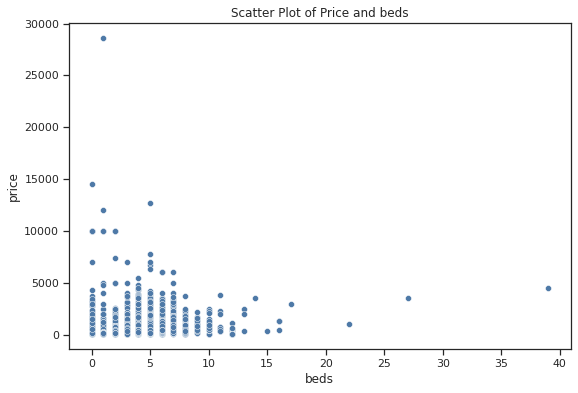


price



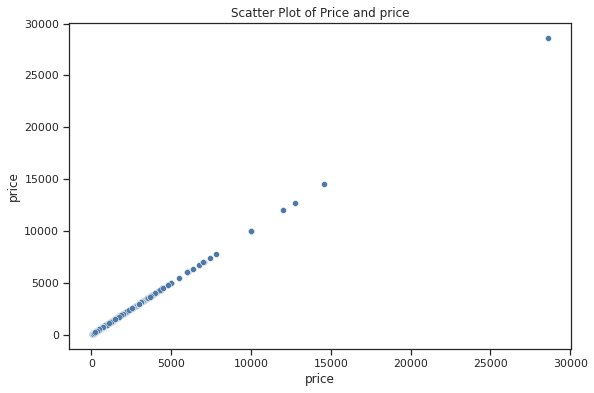


minimum_nights



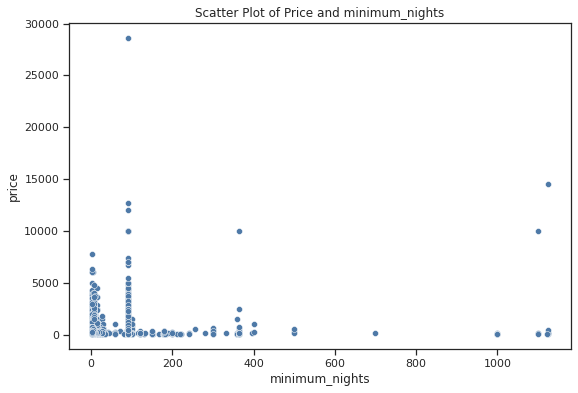


maximum_nights



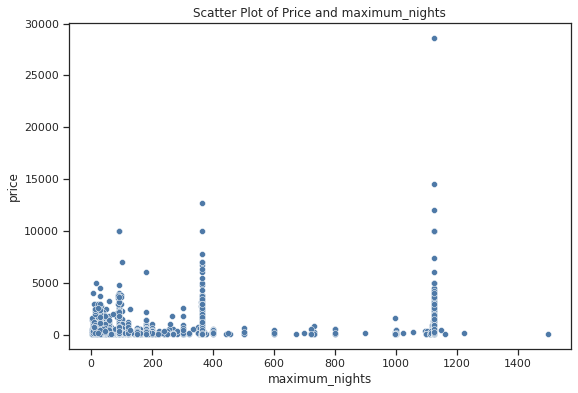


minimum_minimum_nights



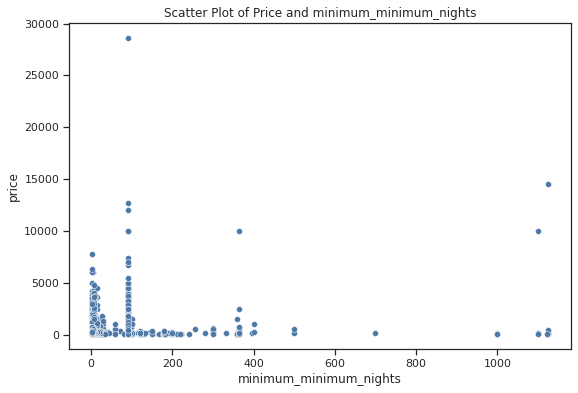


maximum_minimum_nights



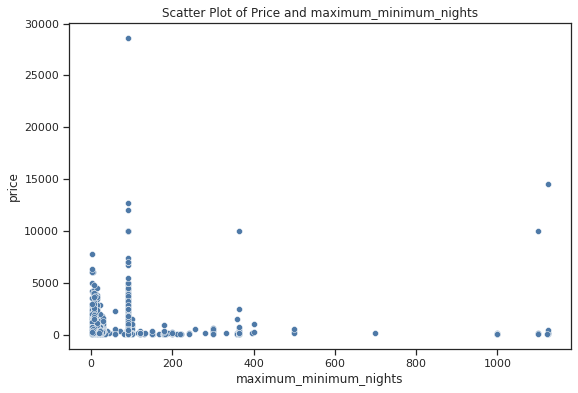


minimum_maximum_nights



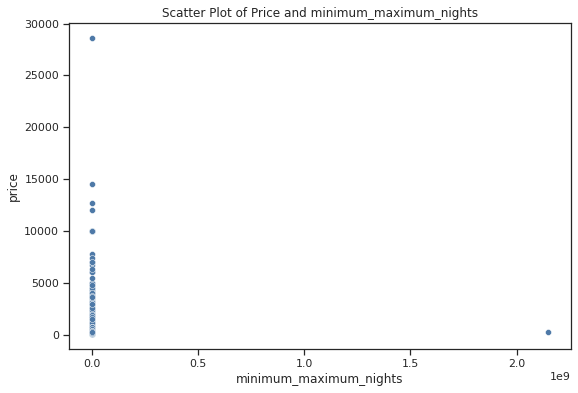


maximum_maximum_nights



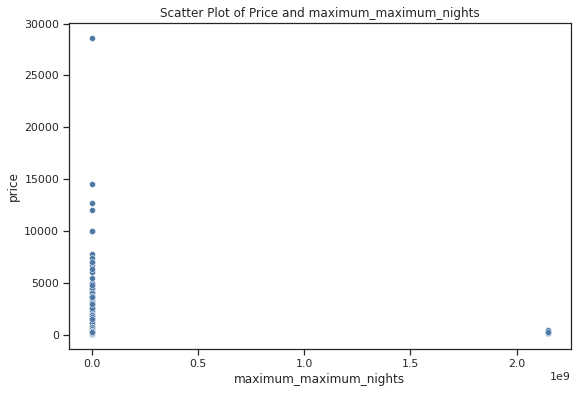


minimum_nights_avg_ntm



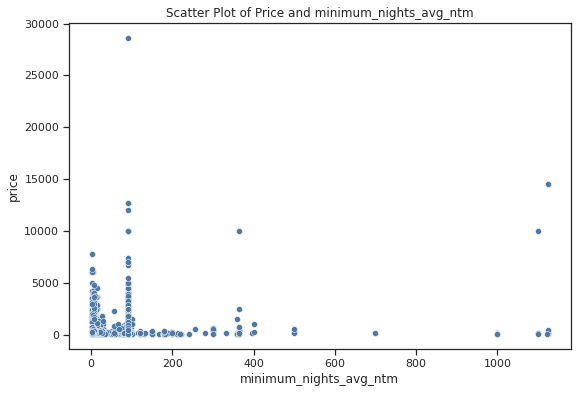


maximum_nights_avg_ntm



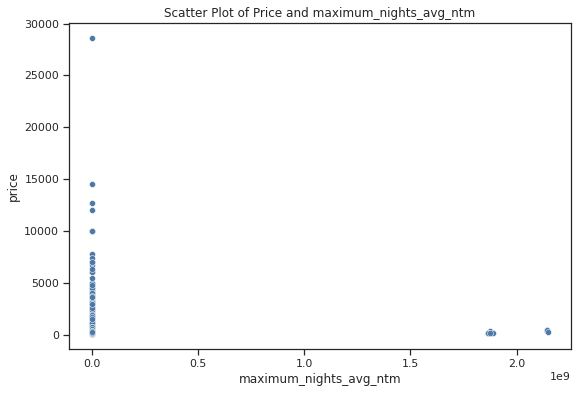


availability_30



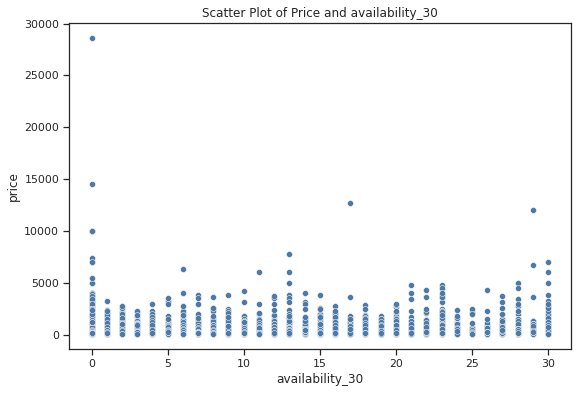


availability_365



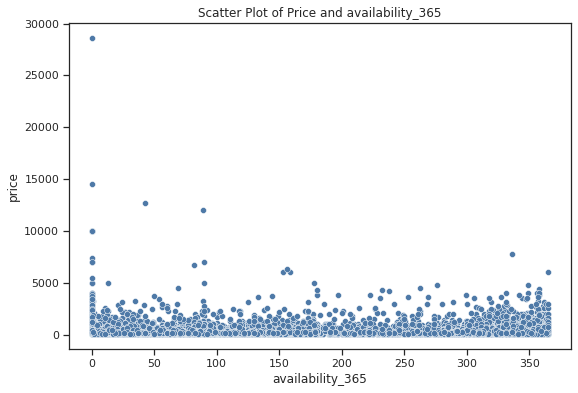


number_of_reviews



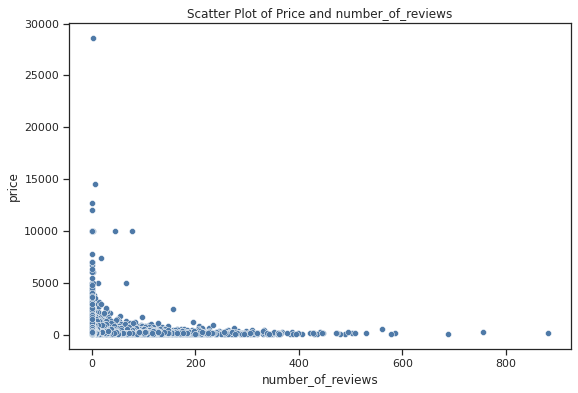


review_rating



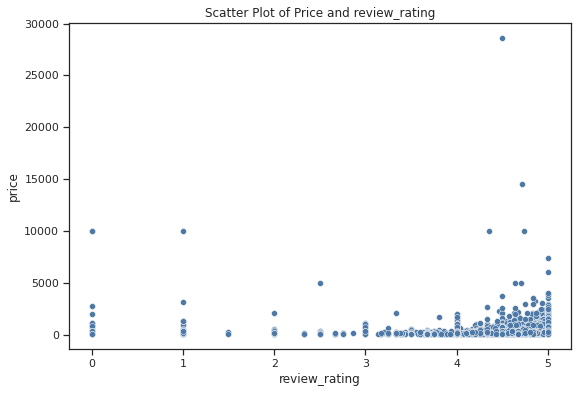


review_accuracy



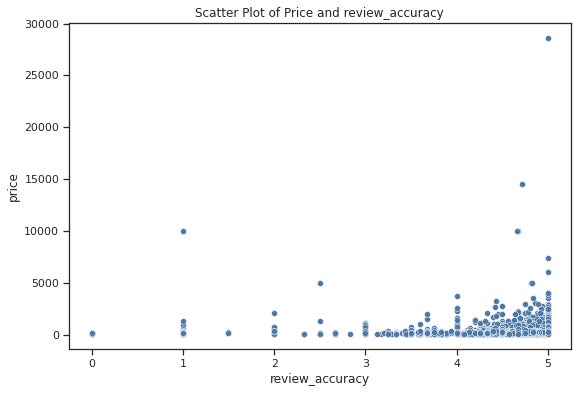


review_cleanliness



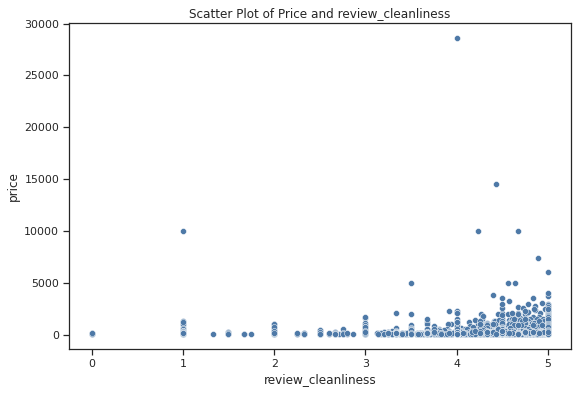


review_checkin



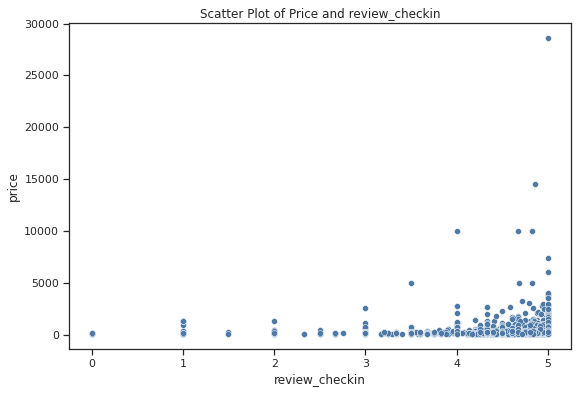


review_communication



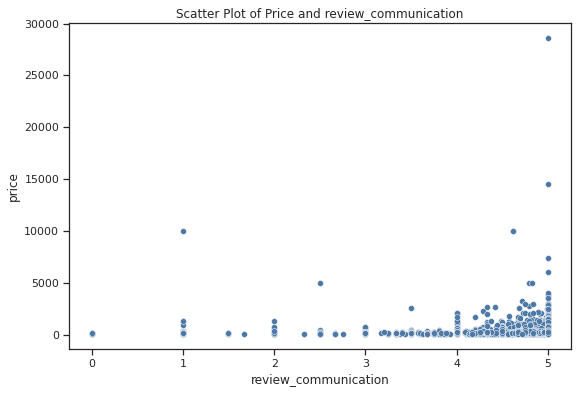


review_location



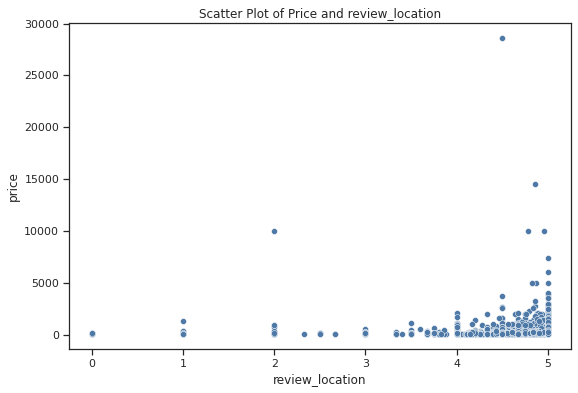


review_value



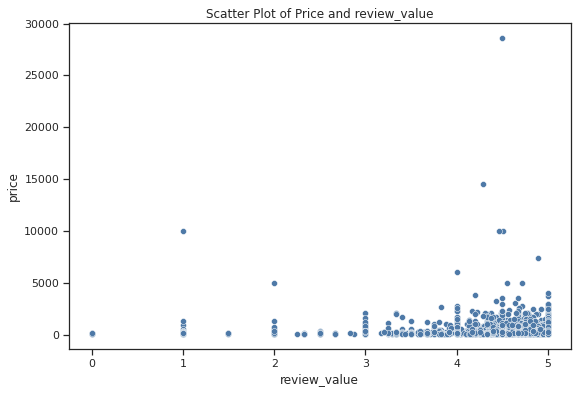


calculated_host_listings_count



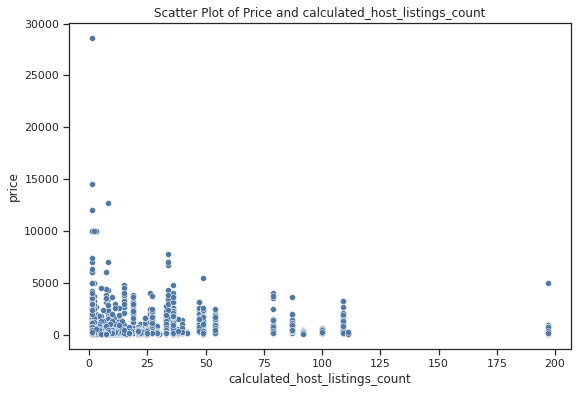


calculated_host_listings_count_entire_homes



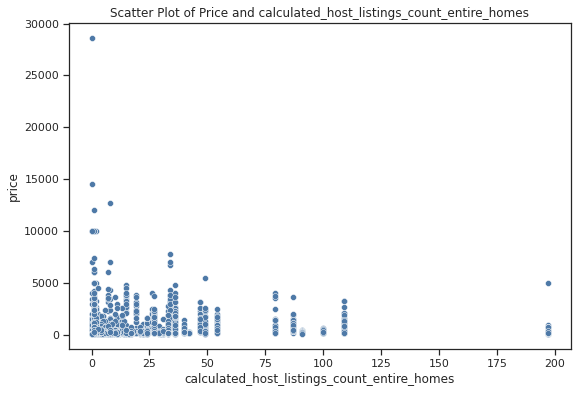


calculated_host_listings_count_private_rooms



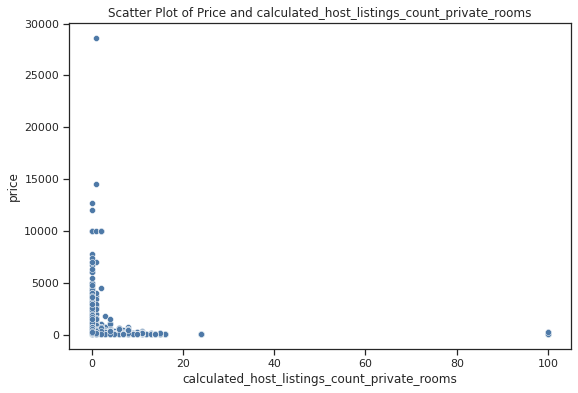


calculated_host_listings_count_shared_rooms



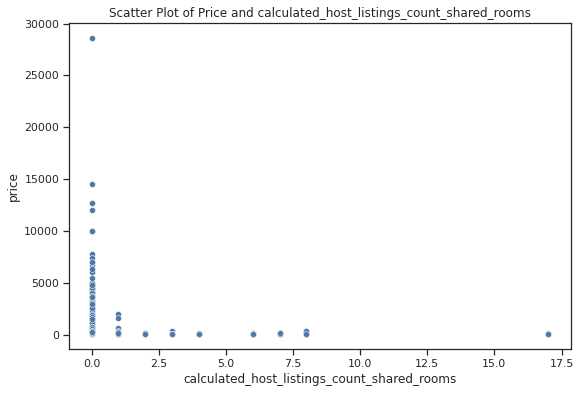


reviews_per_month



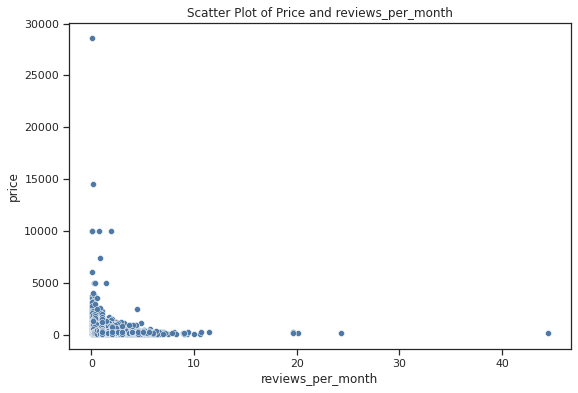

In [23]:
continuous_variables = []
for x in data_bivariate.columns:
  if isinstance(data[x][0], float) or isinstance(data[x][0], np.integer) or x == 'host_since':
    numerical_bivariate_EDA(x)
    if x != 'host_since':
      continuous_variables.append(x)

In [24]:
print(continuous_variables)

['response_percent', 'acceptance_percent', 'listings_count', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_365', 'number_of_reviews', 'review_rating', 'review_accuracy', 'review_cleanliness', 'review_checkin', 'review_communication', 'review_location', 'review_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']


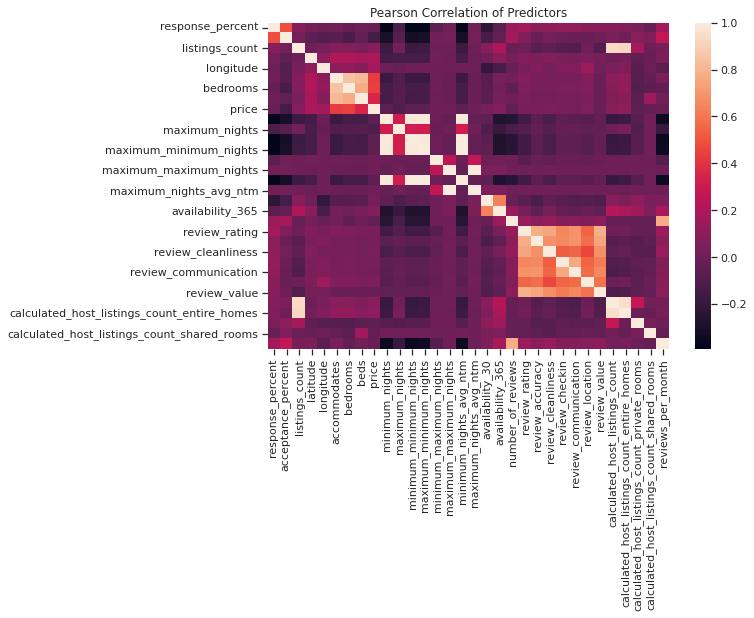

In [25]:
correlations = data_bivariate[continuous_variables].corr()

plt.title('Pearson Correlation of Predictors')
sns.heatmap(correlations)

In [112]:
correlations_price = pd.DataFrame(correlations.iloc[:, 8]).sort_values(by = 'price')
correlations_price

,price
acceptance_percent,-0.141284
maximum_nights,-0.100982
calculated_host_listings_count_private_rooms,-0.054353
minimum_minimum_nights,-0.054058
minimum_nights_avg_ntm,-0.052936
minimum_nights,-0.052247
maximum_minimum_nights,-0.051017
number_of_reviews,-0.043295
calculated_host_listings_count_shared_rooms,-0.033078
response_percent,-0.020005


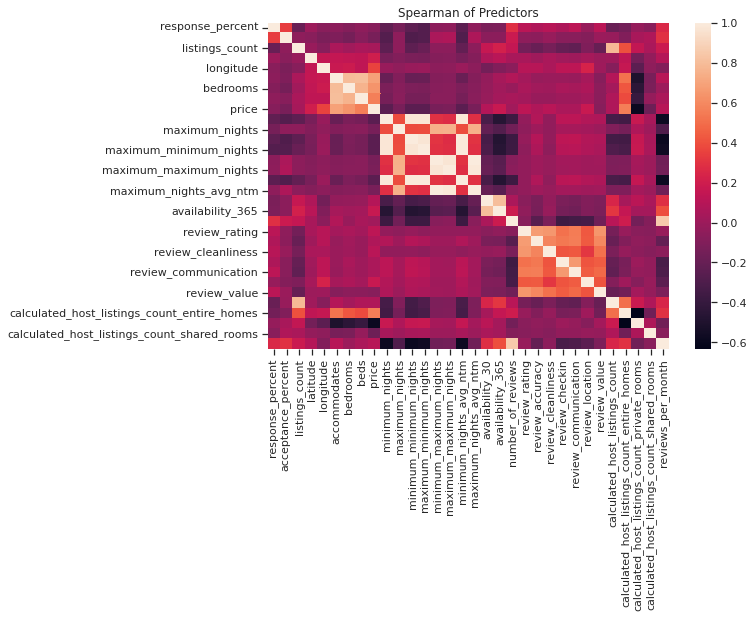

In [26]:
correlations = data_bivariate[continuous_variables].corr(method="spearman")

plt.title('Spearman of Predictors')
sns.heatmap(correlations)

In [27]:
correlations_price = pd.DataFrame(correlations.iloc[:, 8]).sort_values(by = 'price')
correlations_price

,price
calculated_host_listings_count_private_rooms,-0.585445
minimum_minimum_nights,-0.248612
minimum_nights,-0.248157
maximum_minimum_nights,-0.243600
minimum_nights_avg_ntm,-0.242998
calculated_host_listings_count_shared_rooms,-0.175225
acceptance_percent,-0.133866
minimum_maximum_nights,-0.132522
maximum_nights,-0.130217
maximum_nights_avg_ntm,-0.129081


### Categorical Bivariate

In [113]:
def categorical_bivariate_EDA(variable):
  x = data[variable]
  y = data['price']

  print(variable)

  print('')

  sns.boxplot(x, y)
  plt.title('Box Plot of Price and {}'.format(variable))

  plt.xticks(rotation='vertical')
  plt.show()


  print('')

In [114]:
for x in data_bivariate.columns:
  if not isinstance(data[x][0], float) and not isinstance(data[x][0], np.integer) and x != 'host_since' and x != 'price':
    print(x)

host_response_time
host_is_superhost
host_verifications
host_has_profile_pic
host_is_verified
neighbourhood
property_type
room_type
bathrooms_text
has_availability
license
instant_bookable


host_response_time



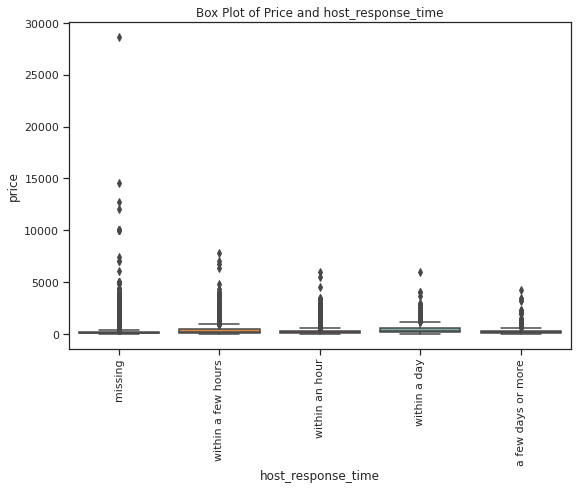


host_is_superhost



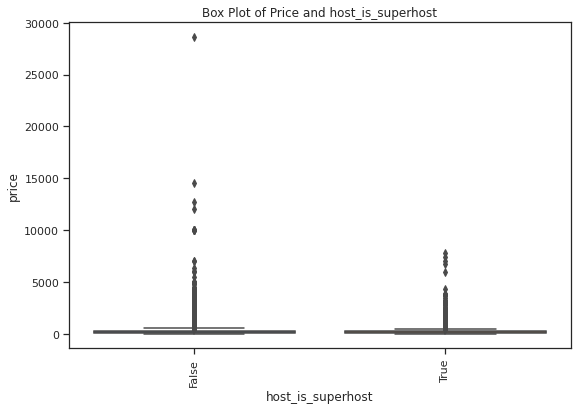


host_verifications



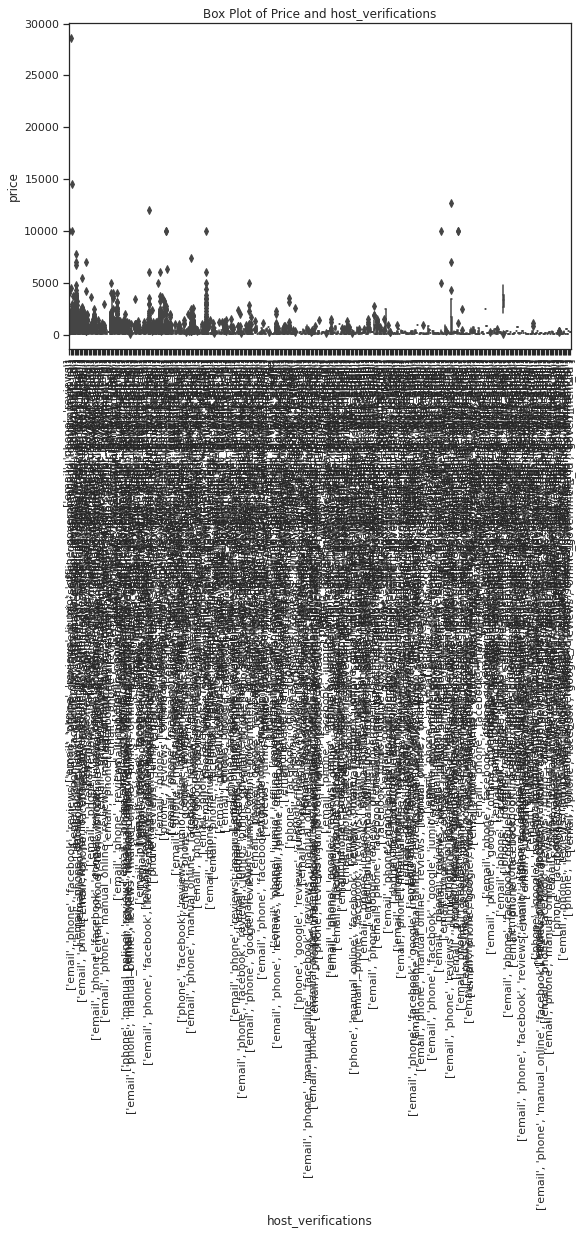


host_has_profile_pic



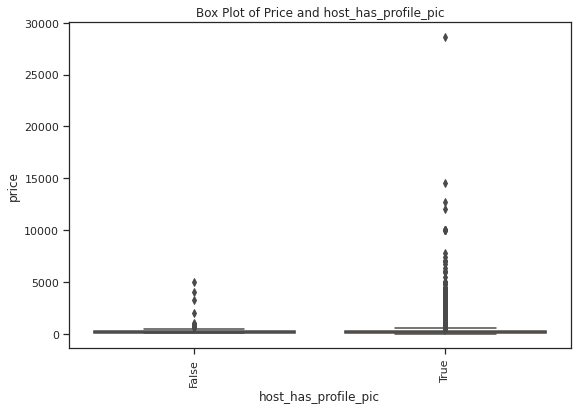


host_is_verified



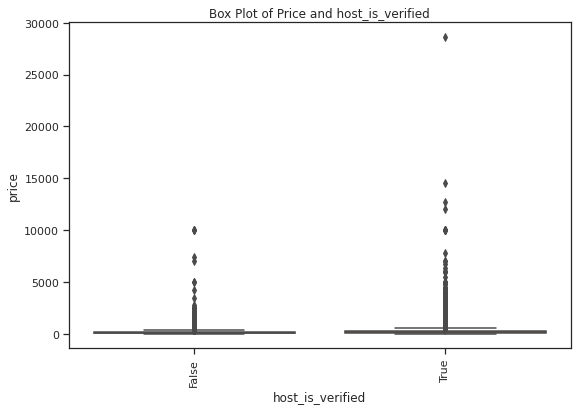


neighbourhood



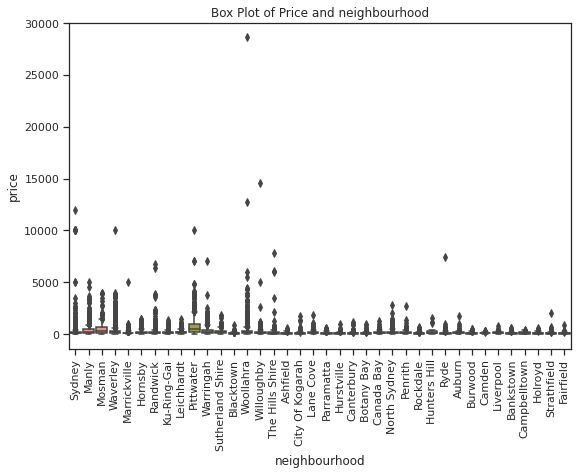


property_type



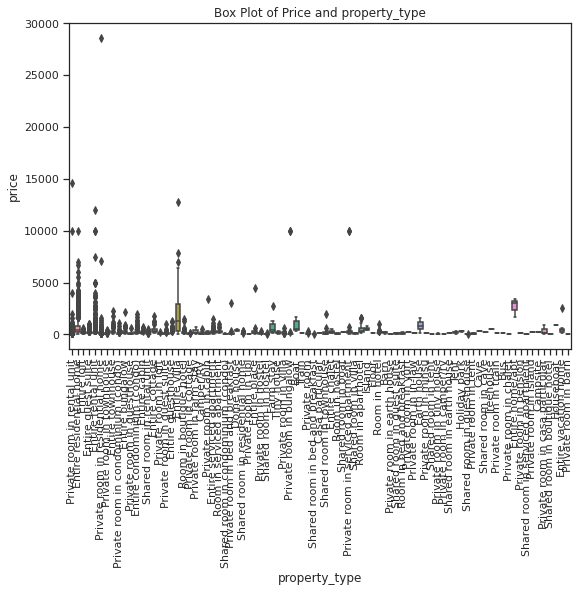


room_type



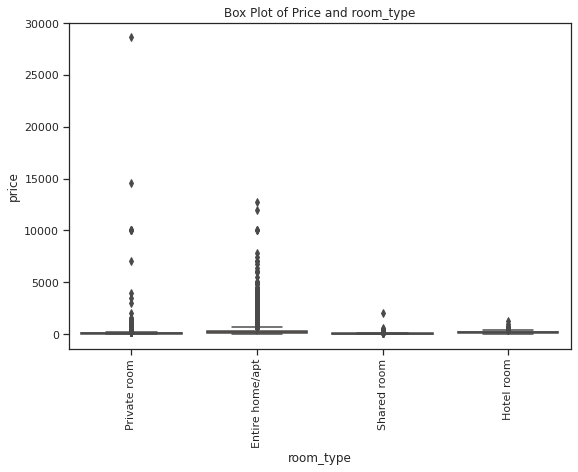


bathrooms_text



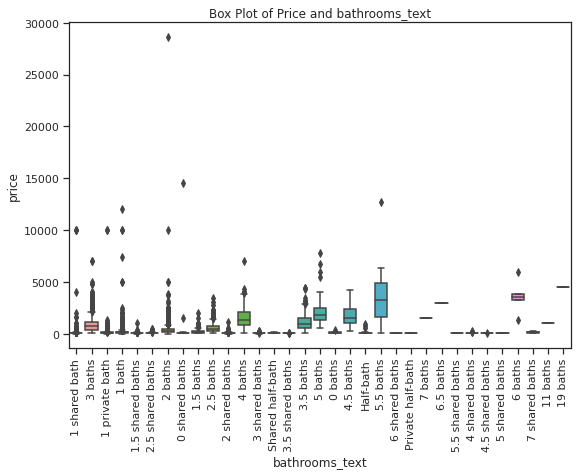


has_availability



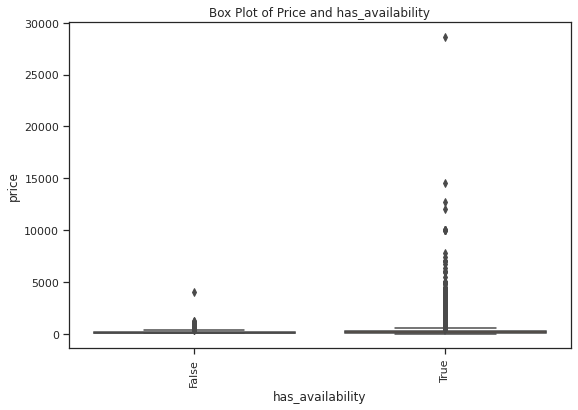


license



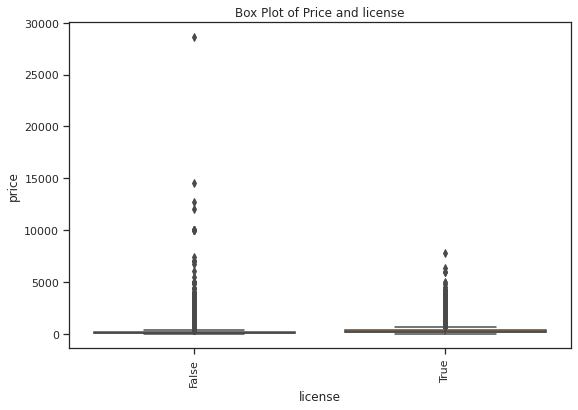


instant_bookable



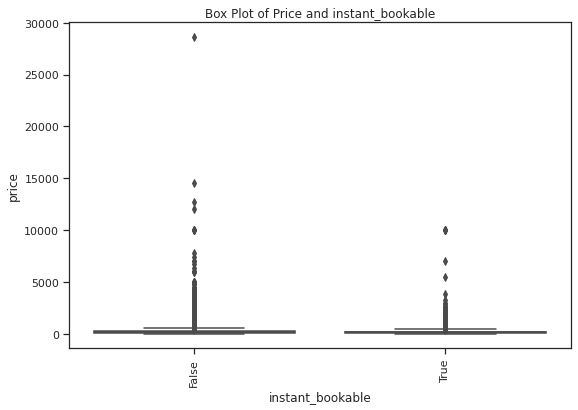

In [115]:
for x in data_bivariate.columns:
  if not isinstance(data[x][0], float) and not isinstance(data[x][0], np.integer) and x not in ['host_since', 'price', 'latitude', 'longitude']:
    categorical_bivariate_EDA(x)

### Location Bivariate

In [ ]:
# !pip install cartopy
# import cartopy

# !pip uninstall -y shapely
# !pip install shapely --no-binary shapely

# !pip install imgaug==0.2.5

In [ ]:
# # Need to fix up a bit (transform price data might help?)

# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# extra = 0.3

# # Latitude and longitude for the edges of the map - CHANGE WITH DATA
# lat1, lat2, lon1, lon2 = data['latitude'].min()-extra, data['latitude'].max()+extra, data['longitude'].min()-extra, data['longitude'].max()+extra

# # Create figures
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(1, 1, 1, projection = ccrs.Mercator())

# # Get latitude and longitude for each data point
# x, y = (data['longitude'].to_numpy(), data['latitude'].to_numpy())

# # Scatter plot as heat map
# ax.scatter(x, y, c=data['price'].to_numpy(), 
#            edgecolors='none', cmap=plt.get_cmap('bwr'), alpha=0.5, transform=ccrs.PlateCarree())

# # Add state borders and coast line
# ax.add_feature(cfeature.STATES.with_scale('50m'))
# ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
# ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())

# # Add title
# ax.set_title('AirBnB Prices in NSW', fontsize=17, y=1.01, fontweight='bold')


# # syd_lon = 151.2093
# # syd_lat = 33.8688

# # plt.plot([syd_lon], [syd_lat],
# #          color='black', linewidth=2, marker='o',
# #          transform=ccrs.Geodetic(),
# #          )

# # plt.text(syd_lon + 3, syd_lat - 12, 'Delhi',
# #          horizontalalignment='left',
# #          transform=ccrs.Geodetic())

# plt.show()

In [ ]:
# # Yeo-Johnsom transformation

# from sklearn.preprocessing import PowerTransformer

# # YJ is the default, the method cannu also do the Box-Cox transformation
# yj = PowerTransformer(method='yeo-johnson')
# train['bedrooms']  = yj.fit_transform(train[['bedrooms']])
# valid['bedrooms'] = yj.transform(valid[['bedrooms']])
